In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance
from tqdm import tqdm
from joblib import Parallel, delayed
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [2]:
from plot import plot_wasserstein_comparison

In [3]:
DATASET_1 = "../../raw_data/massive_complete.parquet"
DATASET_2 = "../../raw_data/proteome.parquet"

In [4]:
def compute_wasserstein_for_sequence(sequence, group, min_files, col='filename'):
    distributions = group.groupby(col)['iRT'].apply(list)
    distributions_dict = {k: v for k, v in distributions.to_dict().items() if len(v) >= min_files}
    filenames = list(distributions_dict.keys())

    if len(filenames) < 2:  # Need at least 2 files to compute distance
        return sequence, None

    distances = [
        wasserstein_distance(distributions_dict[file1], distributions_dict[file2])
        for file1, file2 in itertools.combinations(filenames, 2)
    ]

    if distances:
        return sequence, sum(distances) / len(distances)
    return sequence, None


def compute_mean_wasserstein_distance(df, min_files, col='filename', n_jobs=19):
    grouped = df.groupby('sequence')
    groups = list(grouped)  # Convert to list for tqdm compatibility

    # Parallel execution with progress bar
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_wasserstein_for_sequence)(sequence, group, min_files, col)
        for sequence, group in tqdm(groups, desc="Processing sequences")
    )

    # Filter out None results and create dictionary
    mean_distances = {seq: dist for seq, dist in results if dist is not None}

    return mean_distances

In [5]:
# Load your datasets
df1 = pd.read_parquet(DATASET_1)
df2 = pd.read_parquet(DATASET_2)

In [6]:
mean_wasserstein1 = compute_mean_wasserstein_distance(df1, 1,'filename')
mean_wasserstein2 = compute_mean_wasserstein_distance(df2, 1,'pool')

Processing sequences: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291394/291394 [00:33<00:00, 8654.46it/s]


Statistics for MassiveKB:
  Mean: 6.92
  Median: 4.60
  Min: 0.00
  Max: 340.37
  Count: 602760

Statistics for Proteome:
  Mean: 3.21
  Median: 1.86
  Min: 0.00
  Max: 134.03
  Count: 26233


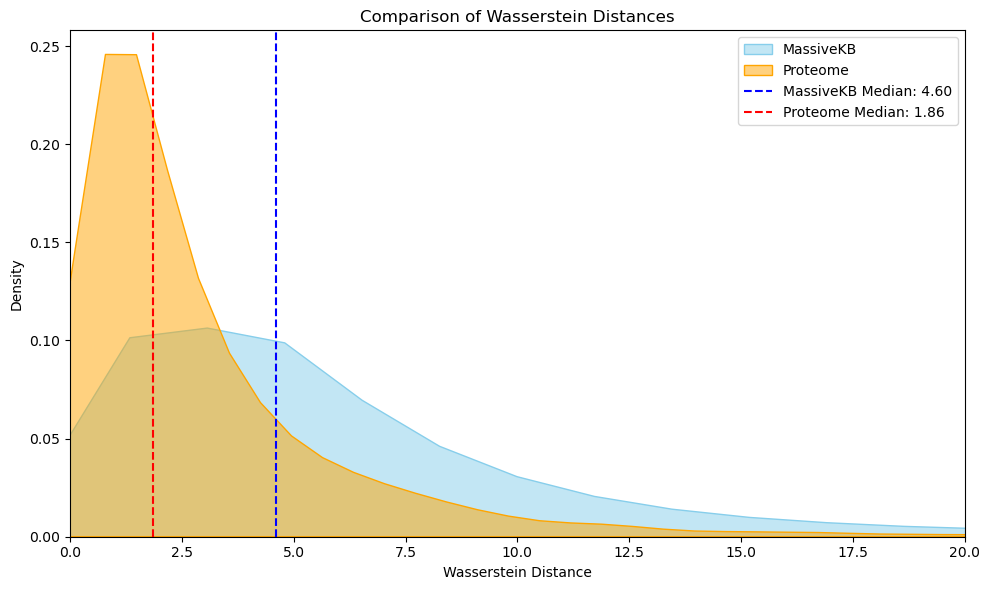

<module 'matplotlib.pyplot' from 'C:\\Users\\lambe\\anaconda3\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [7]:
# Plot the comparison
plot_wasserstein_comparison(
    mean_wasserstein1, 
    mean_wasserstein2,
    label1="MassiveKB", 
    label2="Proteome"
)